In [1]:
 """Part I. ETL Pipeline for Pre-Processing the Files"""

'Part I. ETL Pipeline for Pre-Processing the Files'

In [2]:
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

In [3]:
"""Creating list of filepaths to process original event csv data files"""

'Creating list of filepaths to process original event csv data files'

In [4]:
#checking your current working dierctory 
print(os.getcwd())
# Get your current folder and subfolder event data
filepath = os.getcwd() + '/event_data'
# Create a for loop to create a list of files and collect each filepath
for root, dirs, files in os.walk(filepath):
   # join the file path and roots with the subdirectories using glob
     file_path_list = glob.glob(os.path.join(filepath,'*'))


e:\Data_Eng\Data_Eng_Udacity\Data_Modeling\Data_modeling_with_Cassandra\Data_modeling_Project


In [7]:
"""Processing the files to create the data file csv that will be used for Apache Casssandra tables"""

'Processing the files to create the data file csv that will be used for Apache Casssandra tables'

In [8]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = []
# for every filepath in the file path list 
for f in file_path_list:
    # reading csv file
    with open(f, 'r', encoding='utf8', newline='') as csvfile:
        #creating a csv reader object
        csvreader = csv.reader(csvfile)
        next(csvreader)
        # extracting each data row one by one and append it
        for line in csvreader:
            print(line)
            full_data_rows_list.append(line)
# uncomment the code below if you would like to get total number of rows 
print(len(full_data_rows_list))
# uncomment the code below if you would like to check to see what the list of event data rows will look like
print(full_data_rows_list)

# creating a smaller event data csv file called event_datafile_full csv that will be used to insert data into the \
# Apache Cassandra tables
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)
with open('event_datafile_new.csv', 'w', encoding='utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if(row[0]==''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))

gged In', 'Kinsley', 'F', '33', 'Young', '275.93098', 'paid', 'Red Bluff, CA', 'PUT', 'NextSong', '1.54047E+12', '977', 'Overload', '200', '1.54359E+12', '85'], ['Gyptian', 'Logged In', 'Rylan', 'M', '13', 'George', '233.09016', 'paid', 'Birmingham-Hoover, AL', 'PUT', 'NextSong', '1.54102E+12', '1076', 'Hold You', '200', '1.54359E+12', '16'], ['Zion / Akon', 'Logged In', 'Rylan', 'M', '14', 'George', '233.19465', 'paid', 'Birmingham-Hoover, AL', 'PUT', 'NextSong', '1.54102E+12', '1076', 'The Way She Moves', '200', '1.54359E+12', '16'], ['Transvision Vamp', 'Logged In', 'Rylan', 'M', '15', 'George', '209.91955', 'paid', 'Birmingham-Hoover, AL', 'PUT', 'NextSong', '1.54102E+12', '1076', 'I Want Your Love', '200', '1.54359E+12', '16'], ['Ry Cooder', 'Logged In', 'Chloe', 'F', '37', 'Cuevas', '201.56036', 'paid', 'San Francisco-Oakland-Hayward, CA', 'PUT', 'NextSong', '1.54094E+12', '1096', 'Corrido de Boxeo', '200', '1.54359E+12', '49'], ['The Pussycat Dolls', 'Logged In', 'Rylan', 'M', '

In [9]:
# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding='utf8') as f:
    print(sum(1 for line in f))

6821


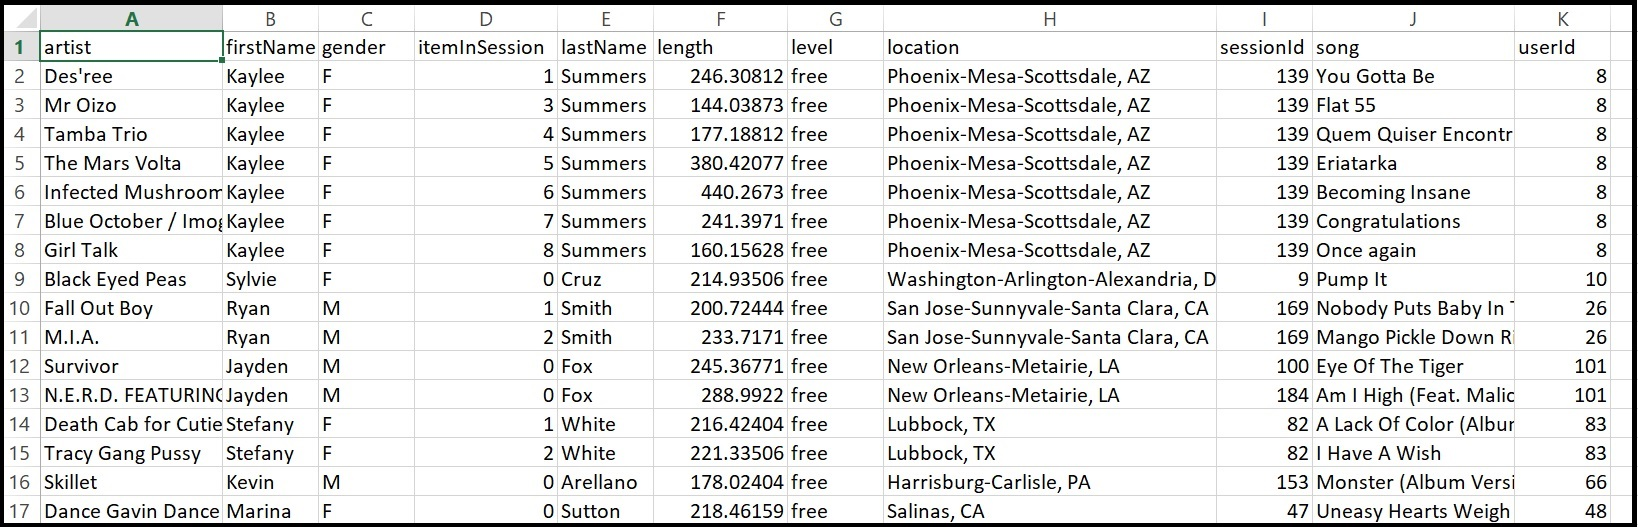

In [15]:
"""Part II. Apache Cassandra coding portion for the project. 

Now you are ready to work with the CSV file titled <font color=red>event_datafile_new.csv</font>, located within the Workspace directory.  The event_datafile_new.csv contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the <font color=red>**event_datafile_new.csv**</font> after the code above is run:<br>"""
from IPython.display import Image
Image(filename="images/image_event_datafile_new.jpg")
#<img src="images/image_event_datafile_new.jpg">

In [17]:
"""Creating a Cluster"""

'Creating a Cluster'

In [10]:
# This should make a connection to a Cassandra instance your local machine 
# (127.0.0.1)
try:
    from cassandra.cluster import Cluster
    cluster = Cluster(['127.0.0.1'])
    # To establish connection and begin executing queries, need a session
    session = cluster.connect()
except Exception as e:
    print(e)


In [12]:
# create keyspace
try:
    session.execute("""
                    CREATE KEYSPACE IF NOT EXISTS sparkifydb
                    WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1}
                    """)
except Exception as e:
    print(e)

In [13]:
try:
    session.set_keyspace("sparkifydb")
except Exception as e:
    print(e)

In [15]:
"""Queries to ask the following three questions of the data"""

'Queries to ask the following three questions of the data'

In [18]:
"""Task-1. Give me the artist, song title and song's length in the music app history that was heard during sessionId = 338, and itemInSession = 4"""


"Task-1. Give me the artist, song title and song's length in the music app history that was heard during sessionId = 338, and itemInSession = 4"

In [19]:
"""For this Task-1, I am creating a table with composite primary key which includes sessionId as partition key and itemInsession as clustering key because I need to
filter the results based on sessionId and itemInSession. SessionId is used a partition key because here we are creating a table of session details where each row
gives information about a particular session. And each session can have multiple itemInSession values."""

'For this Task-1, I am creating a table with composite primary key which includes sessionId as partition key and itemInsession as clustering key because I need to\nfilter the results based on sessionId and itemInSession. SessionId is used a partition key because here we are creating a table of session details where each row\ngives information about a particular session. And each session can have multiple itemInSession values.'

In [20]:
query = "create table if not exists song_history_by_session_and_iteminSession"
query = query + "(sessionId int, itemInSession int, artist text, song text, length float, primary key((sessionId),itemInSession))"
try:
    session.execute(query)
except Exception as e:
    print(e)

In [21]:
"""Insert values from the csv file into the newly created song_history_by_session_and_iteminSession."""

'Insert values from the csv file into the newly created song_history_by_session_and_iteminSession.'

In [28]:
try:
    file = 'event_datafile_new.csv'

    with open(file, encoding = 'utf8') as f:
        csvreader = csv.reader(f)
        next(csvreader) # skip header
        for line in csvreader:
            query = "INSERT INTO song_history_by_session_and_iteminSession (sessionId, itemInSession, artist, song, length)"
            query = query + " VALUES (%s, %s, %s, %s, %s)"
            session.execute(query, ( int(line[8]), int(line[3]), line[0], line[9], float(line[5])))
except Exception as e:
    print(e)

In [23]:
"""SELECT to verify that the data have been inserted into each table"""

'SELECT to verify that the data have been inserted into each table'

In [29]:
try:
    query = "select artist,song,length from song_history_by_session_and_iteminSession where sessionId=338 and itemInSession=4"
    rows = session.execute(query)
except Exception as e:
    print(e)

for row in rows:
    print(row)


Row(artist='Faithless', song='Music Matters (Mark Knight Dub)', length=495.30731201171875)


In [30]:
"""Task-2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182"""

'Task-2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182'

In [31]:
"""For this Task-2, I am creating a table with composite primary key which includes (userId and sessionId) as partition key and itemInsession as clustering key because
the query requires song to be sorted by itemInSession. So, only itemInSession should be used as the clustering key. But to uniquely identify each row in the table we
require userId and SessionId as well. So, I am including userId and sessionId as partition key and itemInSession as clustering key to satisfy the sorted condition."""

'For this Task-2, I am creating a table with composite primary key which includes (userId and sessionId) as partition key and itemInsession as clustering key because\nthe query requires song to be sorted by itemInSession. So, only itemInSession should be used as the clustering key. But to uniquely identify each row in the table we\nrequire userId and SessionId as well. So, I am including userId and sessionId as partition key and itemInSession as clustering key to satisfy the sorted condition.'

In [32]:
try:
    query = "create table if not exists song_history_by_user_and_session "
    query = query + "( userId int, sessionId int, itemInSession int, artist text, user text, song text, primary key((userId,sessionid),itemInSession))"
    session.execute(query)
except Exception as e:
    print(e)

In [33]:
"""Insert values from the csv file into the newly created table."""

'Insert values from the csv file into the newly created table.'

In [35]:
try:
    file = 'event_datafile_new.csv'

    with open(file, encoding = 'utf8') as f:
        csvreader = csv.reader(f)
        next(csvreader) # skip header
        for line in csvreader:
            user = line[1]+" "+line[4]
            query = "INSERT INTO song_history_by_user_and_session (userId, sessionId, itemInSession, artist, user, song)"
            query = query + " VALUES (%s, %s, %s, %s, %s, %s)"
            session.execute(query, ( int(line[10]), int(line[8]), int(line[3]), line[0], user, line[9]))
except Exception as e:
    print(e)

In [36]:
"""SELECT to verify that the data have been inserted into each table"""

'SELECT to verify that the data have been inserted into each table'

In [37]:
try:
    query = "select artist,song,user from song_history_by_user_and_session where userId = 10 and sessionId = 182"
    rows = session.execute(query)
except Exception as e:
    print(e)
for row in rows:
    print(row)

Row(artist='Down To The Bone', song="Keep On Keepin' On", user='Sylvie Cruz')
Row(artist='Three Drives', song='Greece 2000', user='Sylvie Cruz')
Row(artist='Sebastien Tellier', song='Kilometer', user='Sylvie Cruz')
Row(artist='Lonnie Gordon', song='Catch You Baby (Steve Pitron & Max Sanna Radio Edit)', user='Sylvie Cruz')


In [38]:
"""Task-3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'"""

"Task-3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'"

In [39]:
"""For this Task-3, I am creating a table with composite primary key which includes song as partition key and userId as clustering key because the query requires
filtering by song, so song should be used in the where condition, that indicates that the data in table needs to be partitioned by song first. And later on
in order to get the unique data I included userId as the clustering key."""


'For this Task-3, I am creating a table with composite primary key which includes song as partition key and userId as clustering key because the query requires\nfiltering by song, so song should be used in the where condition, that indicates that the data in table needs to be partitioned by song first. And later on\nin order to get the unique data I included userId as the clustering key.'

In [40]:
try:
    query = "create table if not exists user_by_song_heard "
    query = query + "( song text, userId int, user text, primary key((song), userId))"
    session.execute(query)
except Exception as e:
    print(e)

In [41]:
"""Insert values from the csv file into the newly created table."""

'Insert values from the csv file into the newly created table.'

In [44]:
try:
    file = 'event_datafile_new.csv'
    
    with open(file, encoding='utf8') as f:
        csvreader = csv.reader(f)
        next(csvreader) # skip header
        for line in csvreader:
            user = line[1]+" "+line[4]
            query = "INSERT INTO user_by_song_heard (song, userId, user)"
            query = query + "VALUES(%s, %s, %s)"
            session.execute(query, (line[9], int(line[10]), user))
except Exception as e:
    print(e)


In [45]:
"""SELECT to verify that the data have been inserted into each table"""

'SELECT to verify that the data have been inserted into each table'

In [46]:
try:
    query = "select song,user from user_by_song_heard where song ='All Hands Against His Own'"
    rows = session.execute(query)
except exception as e:
    print(e)
for row in rows:
    print(row)

Row(song='All Hands Against His Own', user='Jacqueline Lynch')
Row(song='All Hands Against His Own', user='Tegan Levine')
Row(song='All Hands Against His Own', user='Sara Johnson')


In [47]:
"""Drop the tables before closing out the sessions"""

'Drop the tables before closing out the sessions'

In [ ]:
# try:
#     query = "drop table song_history_by_session_and_iteminSession"
#     rows = session.execute(query)
# except Exception as e:
#     print(e)
# try:
#     query = "drop table song_history_by_user_and_session"
#     rows = session.execute(query)
# except Exception as e:
#     print(e)
# try:
#     query = "drop table user_by_song_heard"
#     rows = session.execute(query)
# except Exception as e:
#     print(e)

In [48]:
"""Close the session and cluster connection"""

'Close the session and cluster connection'

In [49]:
session.shutdown()
cluster.shutdown()